In [1]:
import pandas as pd
from pymrmre import mrmr
from itertools import chain
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
import warnings
warnings.simplefilter(action='ignore')

# Procedure
1. Import Genomics data
2. Run feature selection (MRMR) on genomics to predictor (OS)
3. Calculate binary genomics features for all combinations of selected features
4. Train Logistic Regression using repeated crossvalidation

In [2]:
## Helper functions
def prep_genomics(df):
    ''' Bring raw Genomics into right format '''
    df.set_index("Unnamed: 0", inplace=True)
    df = df.T
    df.reset_index(inplace=True)
    df = df.rename(columns={"index":"oncotech_id"})
    return df

def use_median_to_build_classes(df, predictor):
    ''' Add column of classes for predictor to dataframe
            Class 0 if value smaller/equal to median
            Class 1 if greather median
    '''
    df["class_"+predictor] = 4
    df["class_"+predictor][df[predictor] <= df[predictor].median()] = 0
    df["class_"+predictor][df[predictor] > df[predictor].median()] = 1
    return df

def get_feat_mrmr(df, y, nr_feat, solution_count):
    ''' Feature filtering using MRMR '''
    y = pd.DataFrame(y)
    solutions = mrmr.mrmr_ensemble(features = df, targets = y, solution_length = nr_feat, solution_count = solution_count)
    return solutions

In [3]:
# Select the clinical endpoint to predict
predictor = "os_days"
nr_features_mrmr = 10
nr_solutions_mrmr = 5

# 1. Import raw discovery Genomics data

In [4]:
# Load raw Genomics data and bring into right format
disc_genes = prep_genomics(pd.read_csv("../../Data/Discovery-GenomicsTop1000-March22023.csv"))
# Load Clinical data of discovery set
disc_clinic = pd.read_csv("../../Data/Discovery-ClinicalData.csv")
# Add class for continuous value (median)
disc_clinic = use_median_to_build_classes(disc_clinic, predictor)
# Merge class to genomics data
disc_genes = disc_genes.merge(disc_clinic[["oncotech_id", "class_"+predictor]], on="oncotech_id")

# save names of the genes
gene_names = disc_genes.columns[1:-1]

# 2. MRMR feature filtering

In [5]:
# Run MRMR for feature filtering
solutions = get_feat_mrmr(disc_genes[gene_names], disc_genes["class_"+predictor], nr_feat=nr_features_mrmr, solution_count=nr_solutions_mrmr)
# all unique feature mrmr returns
unique_selected_feats = list(set(list(chain.from_iterable(solutions[0]))))
print("MRMR with {} features for each of the {} solutions comes out with {} unique genes/features.".format(nr_features_mrmr, nr_solutions_mrmr, len(unique_selected_feats)))

MRMR with 10 features for each of the 5 solutions comes out with 15 unique genes/features.


# 3. Calculate binary combinations for selected features

In [6]:
def get_binary_feats(df):
    gene_names = list(df.columns)[:-1]
    df_genes_only = df[gene_names]

    comp_df = pd.DataFrame(index=range(len(df)))
    comp_df["class_os_days"] = df["class_"+predictor]
    for i in range(len(gene_names)):
        for j in range(len(gene_names)):
            if i == j:
                continue
            #print(i, j)
            gene1 = df_genes_only.iloc[:,i]
            gene2 = df_genes_only.iloc[:,j]
            comp_df[gene1.name + "<" + gene2.name] = gene1 < gene2
            comp_df[gene1.name + "<" + gene2.name] = comp_df[gene1.name + "<" + gene2.name].astype(int)
            comp_df[gene1.name + ">" + gene2.name] = gene1 > gene2
            comp_df[gene1.name + ">" + gene2.name] = comp_df[gene1.name + ">" + gene2.name].astype(int)
    return comp_df

In [7]:
disc_genes_selected = disc_genes[unique_selected_feats + ["class_"+predictor]]
disc_binary_feats = get_binary_feats(disc_genes_selected)

# 4. Repeated cross-validation for classification

In [8]:
binary_features = list(disc_binary_feats.columns[1:])

In [9]:
# Source: https://machinelearningmastery.com/repeated-k-fold-cross-validation-with-python/ 
from scipy.stats import sem
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot

In [10]:
cv_splits = 5
n_repeats_cv = 10
random_state = 42

In [11]:
# dataset
X, y = disc_binary_feats[binary_features], disc_binary_feats["class_"+predictor]
# create model
model = LogisticRegression()

# prepare the cross-validation procedure
cv = RepeatedKFold(n_splits=cv_splits, n_repeats=n_repeats_cv, random_state=random_state)
# evaluate model
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.809 (0.115)


In [19]:
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold

# Define svr here
svr = SVC()
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}

# Specify cross-validation generator, in this case (10 x 5CV)
cv = RepeatedKFold(n_splits=cv_splits, n_repeats=n_repeats_cv)
clf = GridSearchCV(estimator=svr, param_grid=param_grid, cv=cv)


scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

# Continue as usual
#clf.fit()

In [21]:
mean(scores)

0.7957142857142857

>1 mean=0.7790 se=0.055
>2 mean=0.7924 se=0.034
>3 mean=0.8102 se=0.027
>4 mean=0.8121 se=0.023
>5 mean=0.8190 se=0.020
>6 mean=0.8121 se=0.017
>7 mean=0.8094 se=0.016
>8 mean=0.8110 se=0.014
>9 mean=0.8058 se=0.014
>10 mean=0.8027 se=0.014
>11 mean=0.8080 se=0.013
>12 mean=0.8055 se=0.013
>13 mean=0.8055 se=0.012
>14 mean=0.8053 se=0.012
>15 mean=0.8072 se=0.011


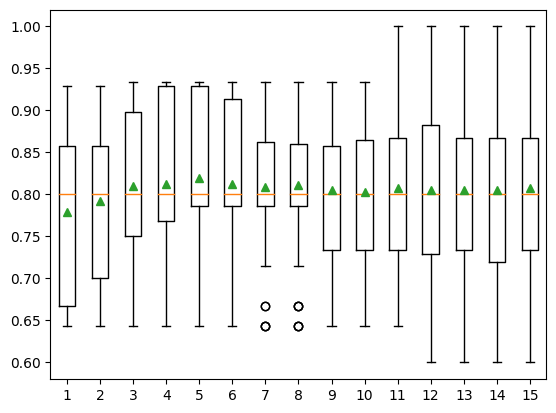

In [12]:
def evaluate_model(X, y, repeats):
    # prepare the cross-validation procedure
    cv = RepeatedKFold(n_splits=5, n_repeats=repeats, random_state=1)
    # create model
    model = LogisticRegression()
    # evaluate model
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

# Test what number of repeats gives the representation of scores
repeats = range(1,16)
results = list()
for r in repeats:
 # evaluate using a given number of repeats
 scores = evaluate_model(X, y, r)
 # summarize
 print('>%d mean=%.4f se=%.3f' % (r, mean(scores), sem(scores)))
 # store
 results.append(scores)
# plot the results
pyplot.boxplot(results, labels=[str(r) for r in repeats], showmeans=True)
pyplot.show()

# 10 or 11 will be good!

In [13]:
model.fit(X,y)


LogisticRegression()

# 5. Test on Validation cohort
1. Load validation set
2. Select filtered features of training cohort
3. Calculate binary features for those
4. Predict on those features

In [14]:
from sklearn.metrics import accuracy_score

In [15]:
# Load raw Genomics data and bring into right format
vali_genes = prep_genomics(pd.read_csv("../../Data/ValidationIUCPQ-March2 2023.csv"))
# Load Clinical data of discovery set
vali_clinic = pd.read_csv("../../Data/ValidationClinicalData.csv")
# Add class for continuous value (median)
vali_clinic = use_median_to_build_classes(vali_clinic, predictor)
# Merge class to genomics data
vali_genes = vali_genes[["oncotech_id"] + unique_selected_feats].merge(vali_clinic[["oncotech_id", "class_"+predictor]], on="oncotech_id")
vali_genes

,oncotech_id,DDX19A,ELOA3D,FEZF2,SPP1,IFNE,ELOA3B,STXBP5L,ATP6V0A4,CP,C12orf29,TMEM132D,IFT172,PF4,GLRX2,ANKRD62,class_os_days
0,038-IUCPQ,3.055110,2.268684e+00,1.401615,6.828100,2.833213,2.908721e+00,2.302585,4.604846,7.145268,3.199103,0.000000,0.960500,0.000000,2.881080,0.000000,0
1,041-IUCPQ,2.895790,0.000000e+00,0.693147,7.777496,0.000000,0.000000e+00,0.000000,0.000000,2.696302,3.510206,0.000000,1.275015,0.693147,2.780425,0.000000,0
2,046-IUCPQ,0.000000,0.000000e+00,0.000000,5.154426,1.386294,1.984072e+00,2.995732,3.625478,1.098612,0.000000,0.000000,2.481266,1.609438,0.341483,0.000000,0
3,017-IUCPQ,3.340584,0.000000e+00,0.693147,6.160111,0.693147,2.302585e+00,2.564949,3.044522,2.085133,4.110878,0.000000,2.452245,0.000000,1.701607,0.000000,1
4,019-IUCPQ,0.000000,4.075438e+00,0.000000,3.254368,0.693147,2.058883e+00,2.397895,0.000000,6.228949,2.936236,1.386294,0.986049,0.000000,2.898816,0.000000,0
5,049-IUCPQ,0.000000,1.118986e-03,0.698573,3.367296,1.945910,2.875548e+00,1.791759,0.693147,2.019688,2.744208,0.000000,3.260332,1.945910,1.237915,1.786474,0
6,021-IUCPQ,3.459338,0.000000e+00,0.000000,6.765973,0.000000,0.000000e+00,2.484907,1.426610,4.007954,4.632258,4.043051,3.029229,3.295837,3.372405,0.000000,1
7,024-IUCPQ,1.414689,0.000000e+00,0.693147,7.648209,3.135494,2.848617e+00,2.708050,2.079442,7.187301,0.000418,0.000000,2.125591,0.693147,1.899622,0.000000,0
8,050-IUCPQ,2.819878,1.656757e+00,0.000000,4.668674,0.000000,0.000000e+00,0.693147,3.044522,5.199221,4.385016,4.094345,3.881478,0.000000,1.023651,0.000000,0
9,025-IUCPQ,0.000000,8.453145e-01,0.000000,7.439086,1.609438,0.000000e+00,3.273550,1.386294,4.363525,0.000000,1.609438,1.805134,1.098612,2.187356,0.000000,0


In [16]:
# Transform to binary features
vali_genes_selected = vali_genes[unique_selected_feats + ["class_"+predictor]]
vali_binary_feats = get_binary_feats(vali_genes_selected)

In [17]:
vali_predictions = model.predict(vali_binary_feats[binary_features])
y_pred = vali_predictions
y_true = vali_binary_feats["class_"+predictor]
print(accuracy_score(y_true, y_pred))

0.5254237288135594


In [18]:
# Have training and test score at same position:
print('Training Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
print('Testing Accuracy: %.3f' % (accuracy_score(y_true, y_pred)))

Training Accuracy: 0.807 (0.098)
Testing Accuracy: 0.525
